In [71]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from pandarallel import pandarallel
from sklearn.model_selection import cross_val_score
import sys
sys.path.insert(1, '/home/andrew/projects/congress_twitter/congress_twitter/scripts')
import text_processing
import spacy
import plotnine as p9
from plotnine.data import mpg
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

In [2]:
from importlib import reload
reload(text_processing)

<module 'text_processing' from '/home/andrew/projects/congress_twitter/congress_twitter/scripts/text_processing.py'>

In [3]:
 p9.options.figure_size = (12, 6.8)

# Overview

Presented here are exploratory analyses of tweets by U.S. Congress members during the years 2020 and part of 2021, with an emphasis on identifying textual or other features that differentiate Democratic and Republican politicians.

# Input data

## Twitter handles

Twitter handles were scraped from a pre-prepared HTML table, with relevant annotations of chamber and party. 

In [45]:
twitter_handles = pd.read_csv("../data/congress_twitter_handles_cleaned.csv")

twitter_handles.head()

,Unnamed: 0,state,chamber,name,Website,party,username,Twitter Links,Instagram,Instagram Links,Facebook,Facebook links
0,0,Alabama,Senator,"Shelby, Richard",https://www.shelby.senate.gov/public/,R,SenShelby,https://twitter.com/SenShelby?ref_src=twsrc%5E...,@senatorshelby,https://www.instagram.com/senatorshelby/,x,https://www.facebook.com/RichardShelby
1,1,Alabama,Senator,"Tuberville, Tommy",https://www.tuberville.senate.gov/,R,Ttuberville,https://twitter.com/ttuberville?lang=en,@sentuberville,https://www.instagram.com/sentuberville/,x,https://www.facebook.com/TommyForSenate/
2,2,Alabama 1st District,Representative,"Carl, Jerry",https://carl.house.gov/,R,RepJerryCarl,https://twitter.com/RepJerryCarl,@repjerrycarl,https://www.instagram.com/repjerrycarl/,x,https://www.facebook.com/RepJerryCarl/
3,3,Alabama 2nd District,Representative,"Moore, Barry",https://barrymoore.house.gov/,R,RepBarryMoore,https://twitter.com/RepBarryMoore?ref_src=twsr...,@barrymooreforcongress,https://www.instagram.com/barrymooreforcongress/,x,https://www.facebook.com/RepBarryMoore/
4,4,Alabama 3rd District,Representative,"Rogers, Mike",http://mikerogers.house.gov/,R,RepMikeRogers,https://twitter.com/repmikerogers?lang=en,@repmikerogersal,https://www.instagram.com/repmikerogersal/?hl=en,x,https://www.facebook.com/CongressmanMikeDRogers/


## All tweets

All tweets from handles believed to belong to members of congress were then scraped.  It appeared as though retweets from other users were also coming through, so an additional filter was added here to require that tweets in the final dataframe were authored by users in the handles dataframe.

In [72]:
all_tweets = pd.read_csv("../data/all_tweets_full.csv")
all_tweets['tweet_content_no_url'] = all_tweets['tweet_content'].apply(lambda x: re.sub(r"\S*https?:\S*", "", x))

In [73]:
#all_tweets = all_tweets[["username", "date", "tweet_content", "party", "chamber", "state", "name"]]
all_tweets.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,username,date,tweet_content,party,state,chamber,name,...,X,PRON,SYM,SCONJ,INTJ,neg,neu,pos,compound,tweet_content_no_url
0,0,0,0.0,RepTerriSewell,2021-07-06 19:45:12+00:00,189 people killed. 540 shootings. In a single ...,D,Alabama 7th District,Representative,"Sewell, Terri A.",...,0.0,0.0,0.0,0.0,0.0,0.364,0.636,0.000,-0.9661,189 people killed. 540 shootings. In a single ...
1,1,1,1.0,RepTerriSewell,2021-07-06 15:24:27+00:00,"🚨ALABAMA FAMILIES🚨\n\nIn just 9 days, hard-wor...",D,Alabama 7th District,Representative,"Sewell, Terri A.",...,3.0,1.0,1.0,0.0,0.0,0.000,0.884,0.116,0.6988,"🚨ALABAMA FAMILIES🚨\n\nIn just 9 days, hard-wor..."
2,2,2,2.0,RepTerriSewell,2021-07-04 15:33:57+00:00,Happy #July4th Alabama!\n\nAs we celebrate our...,D,Alabama 7th District,Representative,"Sewell, Terri A.",...,5.0,7.0,0.0,0.0,0.0,0.079,0.517,0.404,0.9686,Happy #July4th Alabama!\n\nAs we celebrate our...
3,3,3,3.0,RepTerriSewell,2021-07-03 00:02:45+00:00,On the 57th anniversary of the #CivilRightsAct...,D,Alabama 7th District,Representative,"Sewell, Terri A.",...,1.0,4.0,1.0,1.0,0.0,0.083,0.711,0.205,0.7600,On the 57th anniversary of the #CivilRightsAct...
4,4,4,4.0,RepTerriSewell,2021-07-02 16:18:27+00:00,Wonderful news from today’s jobs report!\n\n✅ ...,D,Alabama 7th District,Representative,"Sewell, Terri A.",...,3.0,1.0,0.0,1.0,0.0,0.000,0.902,0.098,0.7412,Wonderful news from today’s jobs report!\n\n✅ ...


In [48]:
pos_cols = ['PRON', 'VERB', 'ADV', 'PROPN', 
            'DET', 'NOUN', 'CCONJ', 'AUX', 
            'ADP', 'PUNCT', 'ADJ', 'X', 'PART',
            'SCONJ', 'SPACE', 'NUM', 'INTJ', 'SYM']

sentiment_cols = ["neg", "neu", "pos", "compound"]




# Exploratory analyses

## Word clouds

In [75]:
dem_all_words = ' '.join([i for i in all_tweets["tweet_content_no_url"][all_tweets["party"] == "D"]])
rep_all_words = ' '.join([i for i in all_tweets["tweet_content_no_url"][all_tweets["party"] == "R"]])

In [76]:
len(dem_all_words)

63307348

In [77]:
len(rep_all_words)

36792306

In [78]:
wordcloud = WordCloud(
    width = 800, 
    height = 500, 
    random_state = 42, 
    max_font_size = 110).generate(dem_all_words)

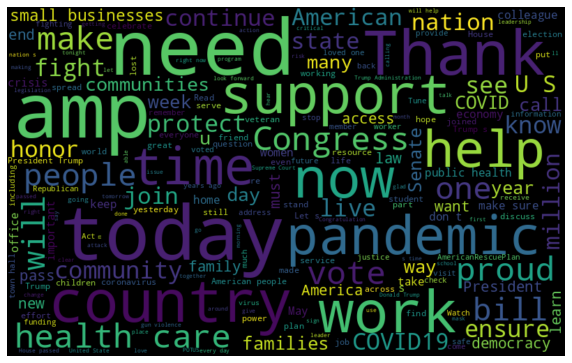

In [79]:
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [80]:
wordcloud = WordCloud(
    width = 800, 
    height = 500, 
    random_state = 42, 
    max_font_size = 110).generate(rep_all_words)

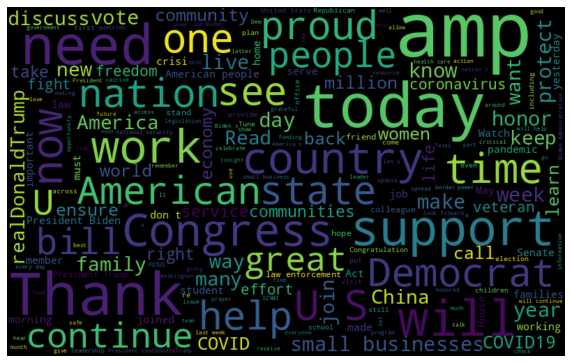

In [81]:
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Tweet Frequencies

In [8]:
tweet_counts = \
    all_tweets.groupby(["username", "party", "chamber", "state"], as_index = False)\
        .size()\
        .sort_values("size",ascending=False)

In [9]:
tweet_counts

,username,party,chamber,state,size
72,JohnCornyn,R,Senator,Texas,4680
7,BillHagertyTN,R,Senator,Tennessee,4602
8,BillPascrell,D,Representative,New Jersey 9th District,4542
490,mtgreenee,R,Representative,Georgia 14th District,4075
418,SenTedCruz,R,Senator,Texas,3754
...,...,...,...,...,...
101,MikeKellyforPA,R,Representative,Pennsylvania 16th District,23
306,RepMoolenaar,R,Representative,Michigan 4th District,18
413,SenSasse,R,Senator,Nebraska,9
41,FallonForTexas,R,Representative,Texas 4th District,5


### Tweets by party

Plotting the density of total tweets in the given time period by individual members of congress seems to show that Democrats tweet on average more frequently than Republicans, in both chambers.

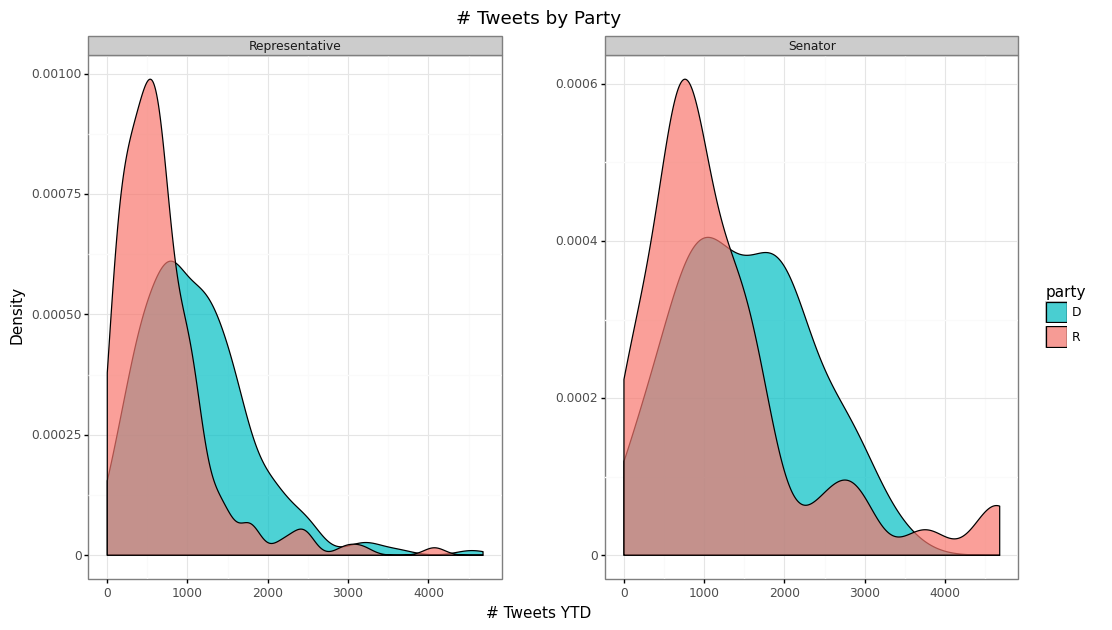

<ggplot: (8764876459002)>

In [10]:
p9.ggplot(
    tweet_counts,
    p9.aes(x = "size",
           fill = "party")) + \
    p9.geom_density(alpha = 0.7) + \
    p9.theme_bw() + \
    p9.ylab("Density") + \
    p9.xlab("# Tweets YTD") + \
    p9.ggtitle("# Tweets by Party") + \
    p9.facet_wrap("~ chamber", scales = "free_y") + \
    p9.theme(subplots_adjust={"wspace": 0.25}) + \
    p9.scale_fill_manual(values = {"D": "#00BFC4", "R": "#F8766D"})

### Tweets by chamber

Switching the grouping to show party in different facets and chamber by shading suggests that senators tweet more often on average than representatives, regardless of party.

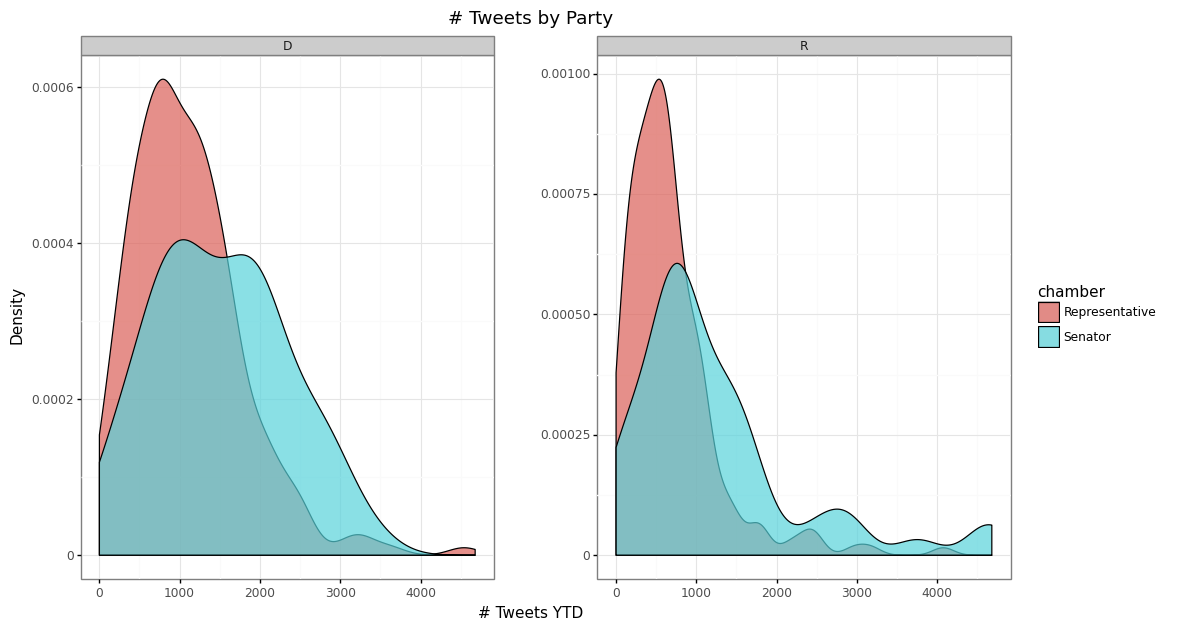

<ggplot: (8764874224927)>

In [11]:
p9.ggplot(
    tweet_counts,
    p9.aes(x = "size",
           fill = "chamber")) + \
    p9.geom_density(alpha = 0.7) + \
    p9.theme_bw() + \
    p9.ylab("Density") + \
    p9.xlab("# Tweets YTD") + \
    p9.ggtitle("# Tweets by Party") + \
    p9.facet_wrap("~ party", scales = "free_y") + \
    p9.theme(subplots_adjust = {"wspace": 0.25})

In [12]:
tweet_counts_person = all_tweets\
    .groupby(["name", "chamber", "state", "party"], as_index = False)\
    .size()\
    .sort_values(by = "size", ascending = False)

tweet_counts_person

,name,chamber,state,party,size
92,"Cornyn, John",Senator,Texas,R,4680
187,"Hagerty, Bill",Senator,Tennessee,R,4602
352,"Pascrell Jr., Bill",Representative,New Jersey 9th District,D,4542
179,"Greene, Marjorie Taylor",Representative,Georgia 14th District,R,4075
105,"Cruz, Ted",Senator,Texas,R,3754
...,...,...,...,...,...
236,"Kelly, Mike",Representative,Pennsylvania 16th District,R,23
313,"Moolenaar, John",Representative,Michigan 4th District,R,18
400,"Sasse, Ben",Senator,Nebraska,R,9
135,"Fallon, Pat",Representative,Texas 4th District,R,5


### Tweet counts by person

Need to replace or eliminate this -- can't see what's going on currently. 

In [13]:
top50_tweeters = tweet_counts_person.iloc[0:50,:].reset_index()

top50_tweeters.head()


,index,name,chamber,state,party,size
0,92,"Cornyn, John",Senator,Texas,R,4680
1,187,"Hagerty, Bill",Senator,Tennessee,R,4602
2,352,"Pascrell Jr., Bill",Representative,New Jersey 9th District,D,4542
3,179,"Greene, Marjorie Taylor",Representative,Georgia 14th District,R,4075
4,105,"Cruz, Ted",Senator,Texas,R,3754


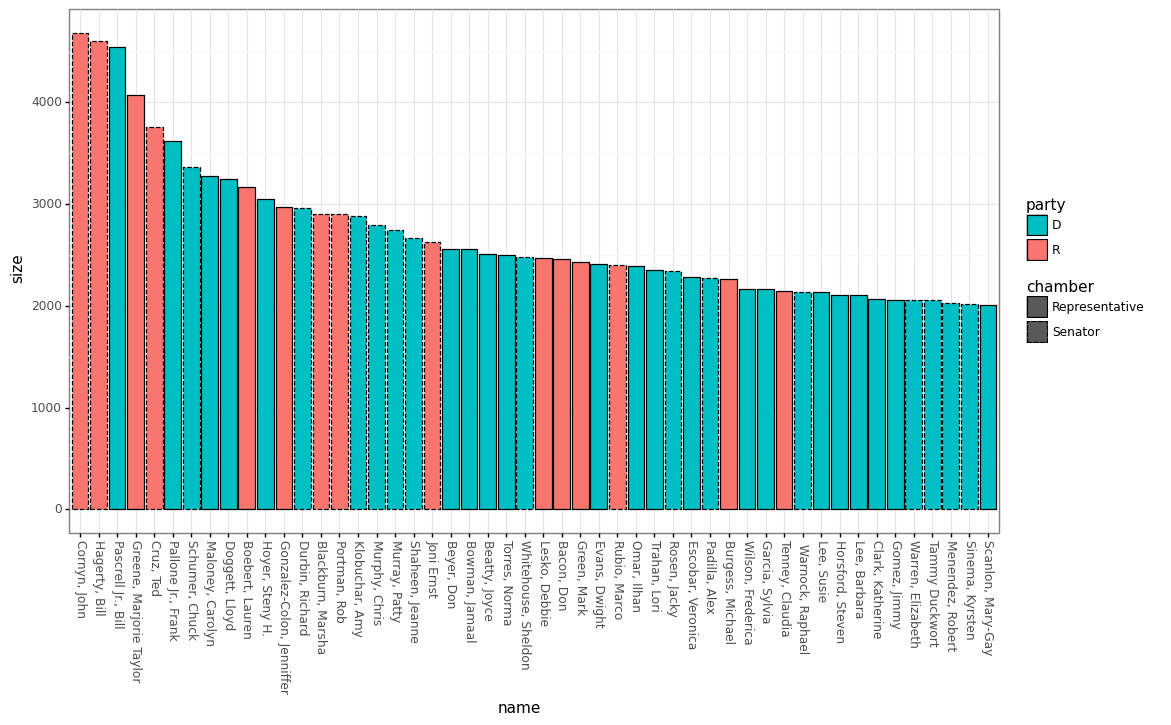

<ggplot: (8764872550900)>

In [14]:
p9.ggplot(
    top50_tweeters,
    p9.aes(x = "name", y = "size", fill = "party", linetype = "chamber")) + \
    p9.geom_col(color = "black") + \
    p9.theme_bw() + \
    p9.theme(axis_text_x = p9.element_text(angle = -90)) + \
    p9.scale_x_discrete(limits = top50_tweeters.name.to_list()) + \
    p9.scale_fill_manual(values = {"D": "#00BFC4", "R": "#F8766D"})

## Sentiment 

### Sentiment by party and chamber

/home/andrew/projects/congress_twitter/venv/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 95'. Pick better value with 'binwidth'.


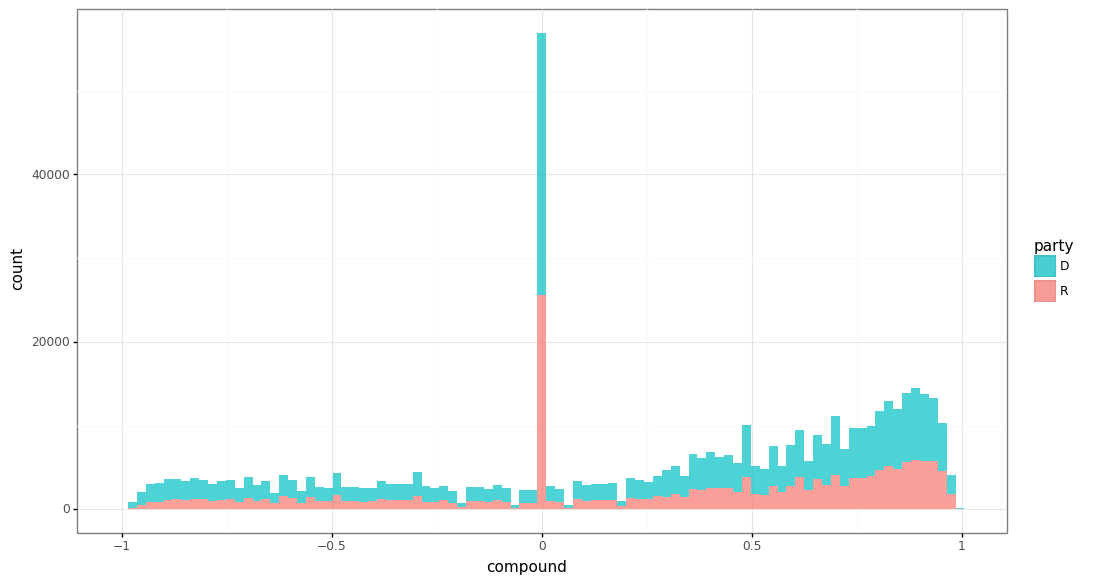

<ggplot: (8764872456183)>

In [15]:
p9.ggplot(
        all_tweets,
        p9.aes(x = "compound", fill = "party")) + \
    p9.geom_histogram(alpha = 0.7) + \
    p9.theme_bw() + \
    p9.scale_fill_manual(values = {"D": "#00BFC4", "R": "#F8766D"})

# Modeling with different feature sets

## Naive Bayes BOW

In [27]:
features = all_tweets["tweet_content"]
response = pd.get_dummies(all_tweets["party"])["D"]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.3, random_state = 42)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [29]:
clf = MultinomialNB()
scores = cross_val_score(clf, X_train, y_train, cv=5)

In [30]:
scores

array([0.83425148, 0.82898398, 0.83320082, 0.83057177, 0.8319348 ])

In [31]:
clf.fit(X_train, y_train)

MultinomialNB()

In [32]:
accuracy = clf.score(X_test, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

The accuracy of the classifier on the test set is 0.837


In [36]:
neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()[::-1]

print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:10]))

['the' 'to' 'co' 'https' 'and' 'of' 'in' 'for' 'is' 'our']
['the' 'to' 'co' 'https' 'and' 'of' 'in' 'for' 'we' 'our']


## Naive Bayes TFIDF

In [32]:
features = all_tweets["tweet_content"].fillna("")
response = pd.get_dummies(all_tweets["party"])["D"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.3, random_state = 42)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [34]:
clf = MultinomialNB()
scores = cross_val_score(clf, X_train, y_train, cv=5)

In [35]:
scores

array([0.75908678, 0.75789414, 0.75887381, 0.75816047, 0.75940992])

In [36]:
clf.fit(X_train, y_train)

MultinomialNB()

In [37]:
accuracy = clf.score(X_test, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

The accuracy of the classifier on the test set is 0.767


## Naive Bayes BOW lemmas

In [38]:
features = all_tweets["tweet_lemmas"].fillna("")
response = pd.get_dummies(all_tweets["party"])["D"]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.3, random_state = 42)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [40]:
clf = MultinomialNB()
scores = cross_val_score(clf, X_train, y_train, cv=5)

In [41]:
scores

array([0.80638062, 0.80085756, 0.806551  , 0.80397836, 0.80579574])

In [42]:
clf.fit(X_train, y_train)

MultinomialNB()

In [43]:
accuracy = clf.score(X_test, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

The accuracy of the classifier on the test set is 0.811


## Naive Bayes TFIDF lemmas

In [44]:
features = all_tweets["tweet_lemmas"].fillna("")
response = pd.get_dummies(all_tweets["party"])["D"]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.3, random_state = 42)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [46]:
clf = MultinomialNB()
scores = cross_val_score(clf, X_train, y_train, cv=5)

In [47]:
scores

array([0.79456781, 0.79049296, 0.79489437, 0.79178203, 0.7928185 ])

In [48]:
clf.fit(X_train, y_train)

MultinomialNB()

In [49]:
accuracy = clf.score(X_test, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

The accuracy of the classifier on the test set is 0.799


## RandomForest sentiment only

In [50]:
features = all_tweets[sentiment_cols]
response = pd.get_dummies(all_tweets["party"])["D"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.3, random_state = 42)


In [52]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, n_jobs = 10)
scores = cross_val_score(clf, X_train, y_train, cv=5)

In [53]:
scores

array([0.57554805, 0.57093367, 0.57280781, 0.57437776, 0.57142451])

In [54]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=10)

In [55]:
accuracy = clf.score(X_test, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

The accuracy of the classifier on the test set is 0.573


## RandomForest sentiment + POS

In [56]:

features = all_tweets[sentiment_cols + pos_cols]
response = pd.get_dummies(all_tweets["party"])["D"]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.3, random_state = 42)


In [58]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, n_jobs = 10)
scores = cross_val_score(clf, X_train, y_train, cv=5)

In [59]:
scores

array([0.63283735, 0.63175829, 0.62984155, 0.63210802, 0.63152589])

In [60]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=10)

In [61]:
accuracy = clf.score(X_test, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

The accuracy of the classifier on the test set is 0.634


## Random Forest BOW lemmas (max 400)

In [63]:
features = all_tweets["tweet_lemmas"].fillna("")
response = pd.get_dummies(all_tweets["party"])["D"]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.3, random_state = 42)
vectorizer = CountVectorizer(max_features=400)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [65]:
clf = RandomForestClassifier(n_estimators=50, n_jobs = 10)
scores = cross_val_score(clf, X_train, y_train, cv = 5)
scores

array([0.72112108, 0.71748637, 0.72266867, 0.72016584, 0.7212875 ])

## Random Forest POS counts only

In [66]:
features = all_tweets[pos_cols]

X_train, X_test, y_train, y_test = train_test_split(features, response, test_size = 0.3, random_state = 42)

In [67]:
clf = RandomForestClassifier(n_estimators = 100, n_jobs = 10)
scores = cross_val_score(clf, X_train, y_train, cv = 5)
scores

array([0.62545434, 0.62468764, 0.62453146, 0.62557681, 0.62465392])

In [68]:
features.shape

(503084, 18)

In [69]:
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

The accuracy of the classifier on the test set is 0.627


# Join parts of speech features to BOW

In [10]:
from sklearn_pandas import DataFrameMapper

In [15]:

features = all_tweets[pos_cols + sentiment_cols + ["tweet_content"]]
features["tweet_content"] = features["tweet_content"].fillna("")

response = pd.get_dummies(all_tweets["party"])["D"]

In [16]:
mapper = DataFrameMapper([
     ('tweet_content', CountVectorizer(max_features=1000)),
     ('PRON', None),
     ('VERB', None),
     ('ADV', None),
     ('PROPN', None),
     ('DET', None),
     ('NOUN', None),
     ('CCONJ', None),
     ('AUX', None),
     ('ADP', None),
     ('PUNCT', None),
     ('ADJ', None),
     ('X', None),
     ('PART', None),
     ('SCONJ', None),
     ('SPACE', None),
     ('NUM', None),
     ('INTJ', None),
     ('SYM', None),
     ("neg", None),
     ("neu", None),
     ("pos", None),
     ("compound", None)
 ])
 

In [17]:
features = mapper.fit_transform(features)

# RandomForest with BOW lemmas, POS counts, and sentiment

In [55]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size = 0.3)

In [ ]:
clf = RandomForestClassifier(n_estimators = 100, n_jobs = 10)
cross_val_score(clf, X_train, y_train, cv = 5)

# Import Twitter wordvecs

In [12]:
wordvec_df = pd.read_csv("../data/all_tweets_wordvecs_twitter_model.csv")
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.027415,-0.013636,-0.024378,0.016550,-0.007959,-0.064032,-0.019062,-0.001433,-0.008456,0.003930,...,0.009139,0.010842,-0.012149,-0.008662,0.022350,0.006717,0.025784,-0.007592,0.041287,0.009364
1,0.019499,-0.019263,-0.013569,0.004794,-0.011026,-0.061204,-0.031215,-0.018016,-0.028740,-0.002673,...,-0.007143,0.003791,-0.030878,-0.004462,0.016406,-0.000015,0.020242,-0.023944,0.037842,0.014401
2,0.010321,-0.010885,-0.038499,0.005563,-0.012886,-0.052517,-0.040876,-0.015291,-0.028828,-0.012038,...,-0.004381,0.000012,-0.000315,0.005396,0.015825,-0.009733,0.031624,-0.004913,0.040995,0.004646
3,0.030225,-0.015861,-0.015956,0.000392,-0.015287,-0.059321,-0.033624,-0.021793,-0.009560,-0.016364,...,-0.017121,-0.030287,-0.015304,0.002037,0.024919,0.000290,0.035930,-0.007623,0.042512,0.005579
4,-0.007814,-0.013048,-0.013579,0.013797,-0.011712,-0.075017,-0.010918,-0.017482,-0.016357,0.000657,...,-0.001361,0.001664,-0.030121,0.004858,0.018026,0.020813,0.039847,-0.010857,0.026325,-0.009206


## Random Forest word2vec only

In [21]:
features = wordvec_df
response = pd.get_dummies(all_tweets["party"])["D"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size = 0.3)

In [23]:
clf = RandomForestClassifier(n_estimators = 100, n_jobs = 10)
cross_val_score(clf, X_train, y_train, cv = 2)

array([0.65453575, 0.65491058])

Traceback (most recent call last):
  File "/home/andrew/software/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/andrew/software/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/andrew/projects/congress_twitter/venv/lib/python3.8/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 215, in <module>
    sys.exit(exitcode)
SystemExit: 0
Traceback (most recent call last):
  File "/home/andrew/software/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/andrew/software/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/andrew/projects/congress_twitter/venv/lib/python3.8/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 215, in <module>
    sys.exit(exitcode)
SystemExit: 0
Traceback (most recent call 

## Random Forest word2vec + sentiment

In [14]:
features = pd.concat([wordvec_df, all_tweets[sentiment_cols]], axis = 1)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,394,395,396,397,398,399,neg,neu,pos,compound
0,0.027415,-0.013636,-0.024378,0.016550,-0.007959,-0.064032,-0.019062,-0.001433,-0.008456,0.003930,...,0.022350,0.006717,0.025784,-0.007592,0.041287,0.009364,0.364,0.636,0.000,-0.9661
1,0.019499,-0.019263,-0.013569,0.004794,-0.011026,-0.061204,-0.031215,-0.018016,-0.028740,-0.002673,...,0.016406,-0.000015,0.020242,-0.023944,0.037842,0.014401,0.000,0.884,0.116,0.6988
2,0.010321,-0.010885,-0.038499,0.005563,-0.012886,-0.052517,-0.040876,-0.015291,-0.028828,-0.012038,...,0.015825,-0.009733,0.031624,-0.004913,0.040995,0.004646,0.079,0.517,0.404,0.9686
3,0.030225,-0.015861,-0.015956,0.000392,-0.015287,-0.059321,-0.033624,-0.021793,-0.009560,-0.016364,...,0.024919,0.000290,0.035930,-0.007623,0.042512,0.005579,0.083,0.711,0.205,0.7600
4,-0.007814,-0.013048,-0.013579,0.013797,-0.011712,-0.075017,-0.010918,-0.017482,-0.016357,0.000657,...,0.018026,0.020813,0.039847,-0.010857,0.026325,-0.009206,0.000,0.902,0.098,0.7412


In [15]:
response = pd.get_dummies(all_tweets["party"])["D"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size = 0.3)

In [20]:
clf = RandomForestClassifier(n_estimators = 100, n_jobs = 10)
cross_val_score(clf, X_train, y_train, cv = 2)

array([0.65713117, 0.65655757])

# Try joining using FeatureUnion

In [103]:
vectorizer = TfidfVectorizer(max_features = 400, preprocessor = build_preprocessor('tweet_content'))
pos_extractor = text_processing.PartsOfSpeechExtractor()

NameError: name 'build_preprocessor' is not defined

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion


X_train, X_test, y_train, y_test = train_test_split(features, response, test_size = 0.3)

pipeline = Pipeline([
    ('feats', FeatureUnion([
        ('tfidf', vectorizer), # can pass in either a pipeline
        ('pos', FeatureSelector(pos_df.columns)) # or a transformer
    ])),
    ('clf', MultinomialNB())  # classifier
])

cross_val_score(pipeline, X_train, y_train, cv = 5)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
